# Visual Pipelines for Text Analysis 

June 25, 2017 &middot; Data Intelligence Conference &middot; Capitol One

## Visual Topic Modeling 

In [1]:
%matplotlib notebook

In [2]:
import os 
import nltk 
import sklearn 
import numpy as np

#import yellowbrick as yb
import matplotlib.pyplot as plt

# Use development version of Yellowbrick 
import sys 
sys.path.append("/Users/benjamin/Repos/ddl/yellowbrick")
import yellowbrick as yb

# Notebook specific utilities 
from utils import * 
from transform import * 
from corpus import BaleenPickledCorpusReader

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
FIXTURES   = os.path.join(os.getcwd(), "fixtures")
ARTICLES   = os.path.join(FIXTURES, "articles")

categories = ['business', 'politics', 'news', 'sports', 'tech', 'cooking']
corpus     = BaleenPickledCorpusReader(ARTICLES)
print(corpus.describes(categories=categories))

Baleen corpus contains 2,021 files in 6 categories.
Structured as:
    36,816 paragraphs (18.217 mean paragraphs per file)
    61,597 sentences (1.673 mean sentences per paragraph).
Word count of 1,365,829 with a vocabulary of 51,227 (26.662 lexical diversity).
Corpus scan took 2.7726128101348877 seconds.


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer 

In [ ]:
vecs = Pipeline([
    ('norm', TextNormalizer()), 
    ('freq', CountVectorizer(tokenizer=identity, preprocessor=None, lowercase=False))
])

docs = vecs.fit_transform(documents(corpus, categories=categories))
lbls = np.array(list(labels(corpus, categories=categories)))

In [ ]:
from yellowbrick.text import FreqDistVisualizer

In [ ]:
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer 

vect = CountVectorizer()
docs = vect.fit_transform(docs)

viz  = FreqDistVisualizer(features=vect.get_feature_names())
viz.fit(docs) 
viz.poof()

In [ ]:
freq = vecs.named_steps['freq']
visualizer = FreqDistVisualizer(features=freq.get_feature_names(), orient='v')
visualizer.fit(docs)
visualizer.poof()

### Simple LDA Model 

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
model = Pipeline([
    ('norm', TextNormalizer()), 
    ('tfidf',  CountVectorizer(
        tokenizer=identity, preprocessor=None, lowercase=False
    )),
    ('lda', LatentDirichletAllocation(n_topics=50)),
])

In [ ]:
X = documents(corpus, categories=categories)
Xt = model.fit_transform(X)

In [ ]:
def topn_words(model, n=10, vectorizer=None):
    vectorizer = vectorizer or model.named_steps['tfidf']
    model  = model if hasattr(model, 'components_') else model.steps[-1][1]
    names  = vectorizer.get_feature_names()
    output = []
    
    for idx, topic in enumerate(model.components_):

        features = topic.argsort()[:-n - 1: -1]
        tokens = [names[i] for i in features]
        
        output.append("Topic #{}".format(idx)) 
        output.append(" ".join(tokens))
        output.append("")
    
    print("\n".join(output))

In [ ]:
topn_words(model)

In [ ]:
N = 50 
T = 10

ax = plt.gca()

names = model.named_steps['tfidf'].get_feature_names()
topics = model.steps[-1][1].components_
wordsum = np.squeeze(np.asarray(topics.sum(axis=0)))
topwords = wordsum.argsort()[:-N - 1: -1]

bins = np.arange(N)
words = [names[i] for i in topwords]
totals = [wordsum[i] for i in topwords]
topic = [topics[T][i] for i in topwords]

ax.bar(bins, totals, label="total")
ax.bar(bins, topic, label="topic #{}".format(T))

# Set the y ticks to the words
ax.set_xticks(bins)
ax.set_xticklabels(words, rotation=90)

# Turn off x grid lines and turn on y grid lines
ax.yaxis.grid(True)
ax.xaxis.grid(False)

plt.legend()

In [ ]:
weights = Xt.sum(axis=0)

In [ ]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=2, svd_solver='full') 
Xpca = pca.fit_transform(model.steps[-1][1].components_)

In [ ]:
pca1 = [x[0] for x in Xpca]
pca2 = [x[1] for x in Xpca]
plt.scatter(pca1, pca2, s=weights*2, alpha=0.7)

for i in range(N):
    plt.annotate(i, (pca1[i],pca2[i]), fontsize=10)

plt.xticks([])
plt.yticks([])
plt.xlabel("PC1")
plt.ylabel("PC2")

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [ ]:
lda = model.named_steps['lda']
vect = model.named_steps['tfidf']
tf = model.steps[1][1].transform(model.steps[0][1].transform(X))
pyLDAvis.sklearn.prepare(lda, tf, vect)

In [19]:
from yellowbrick.text import TSNEVisualizer

vect = Pipeline([
    ('norm', TextNormalizer()), 
    ('tfidf',  TfidfVectorizer(
        tokenizer=identity, 
        preprocessor=None, 
        lowercase=False,
        max_features=5000,
    )),
])

y = labels(corpus, categories=categories)
X = documents(corpus, categories=categories)
Xt = vect.fit_transform(X)

tsne = TSNEVisualizer()
tsne.fit(Xt, y)
tsne.poof()

<IPython.core.display.Javascript object>


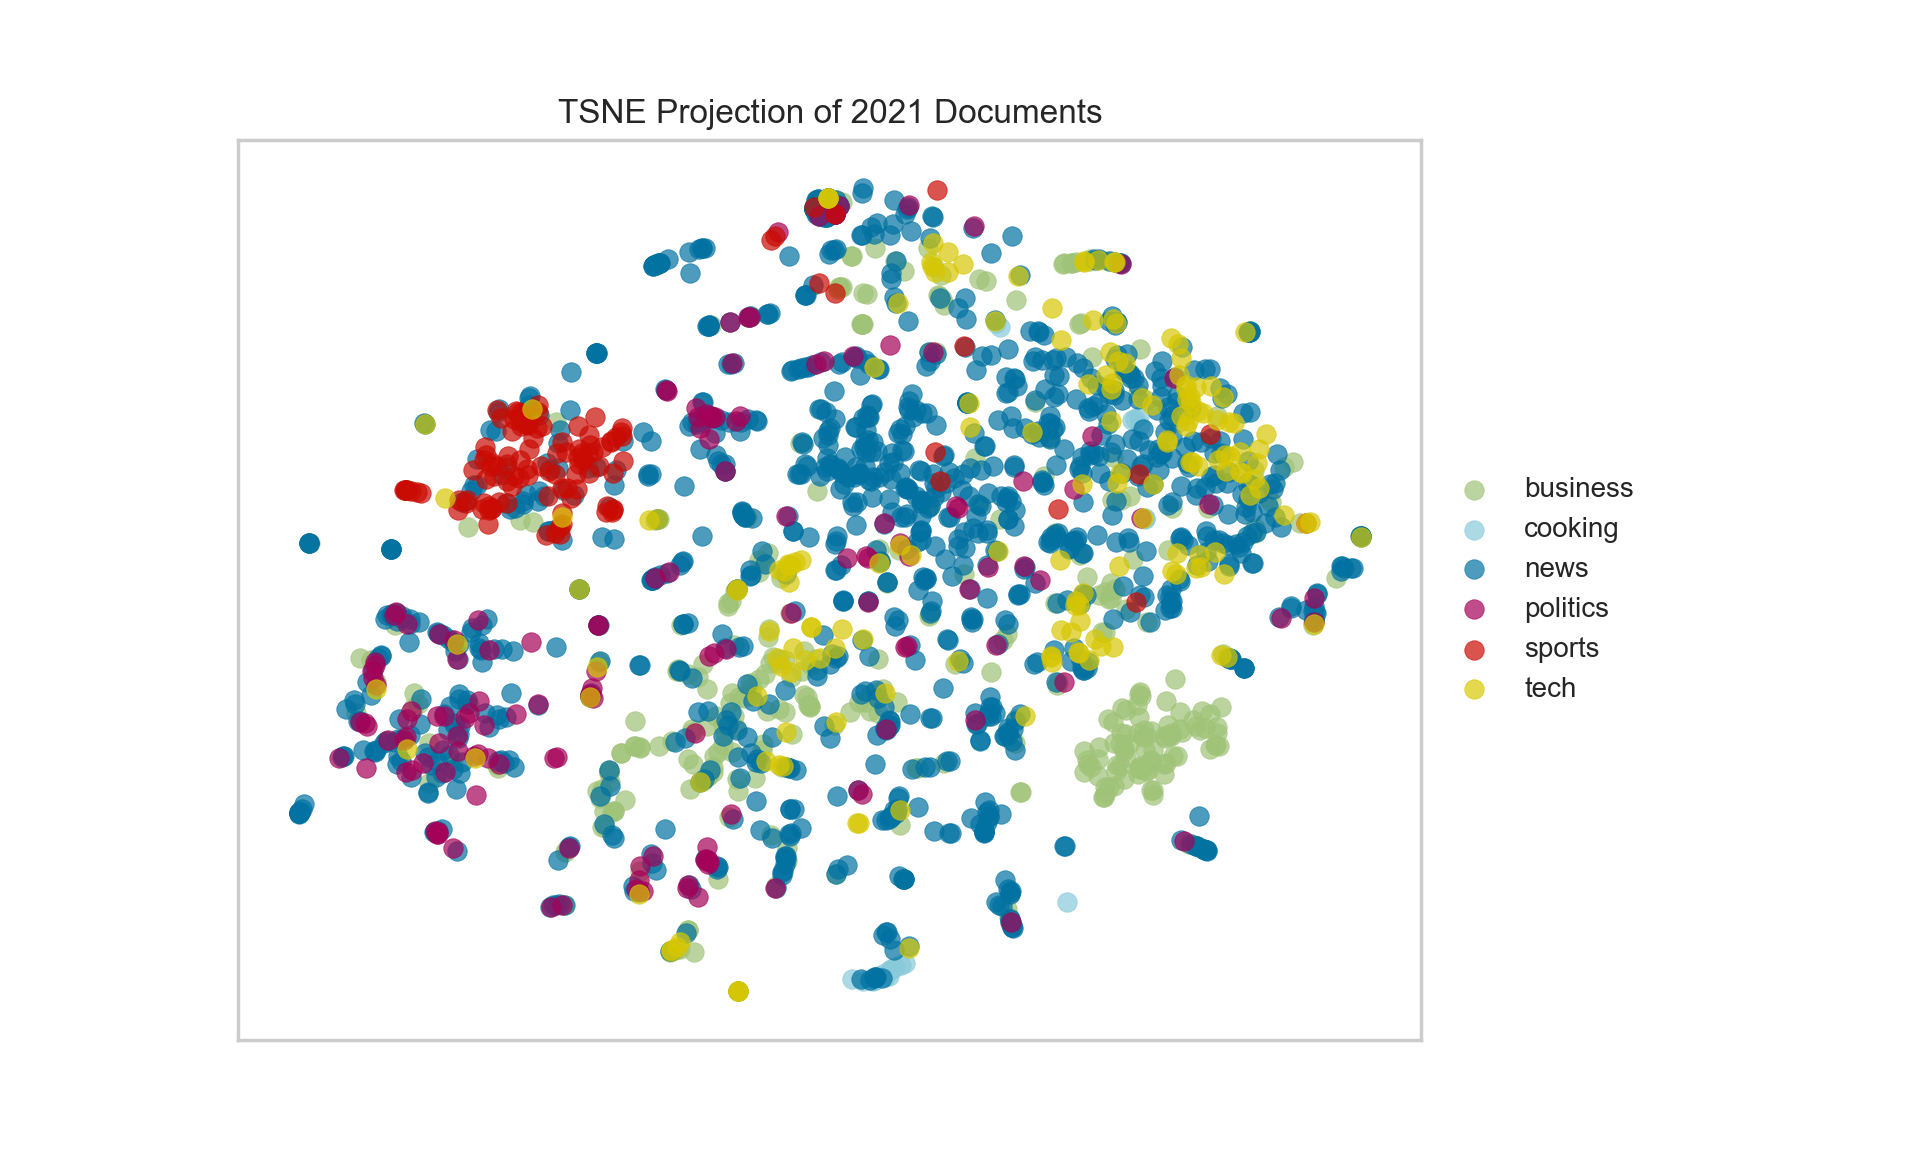

In [7]:
tsne = TSNEVisualizer()
tsne.fit(Xt, list(labels(corpus, categories=categories)))
tsne.poof()

In [14]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from yellowbrick.cluster import KElbowVisualizer 
from yellowbrick.cluster import SilhouetteVisualizer  

<IPython.core.display.Javascript object>


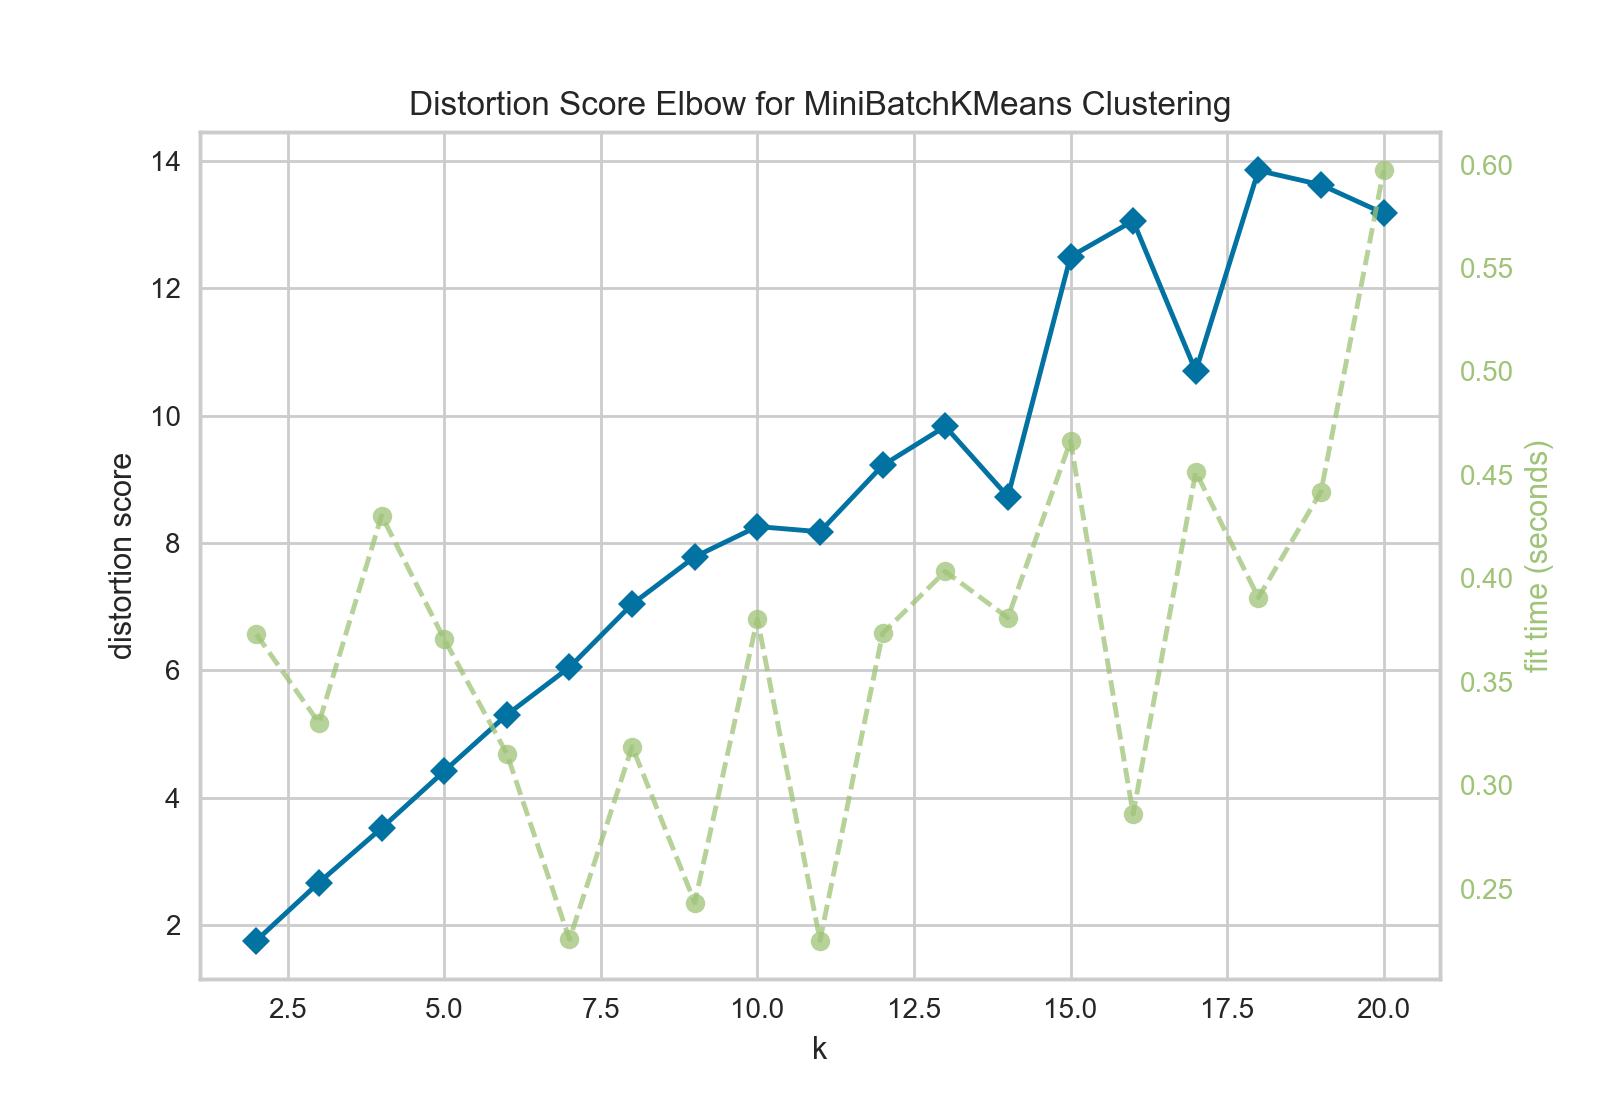

In [27]:
viz = KElbowVisualizer(MiniBatchKMeans(), metric='distortion', k=20)
viz.fit(Xt.toarray())
viz.poof()

<IPython.core.display.Javascript object>


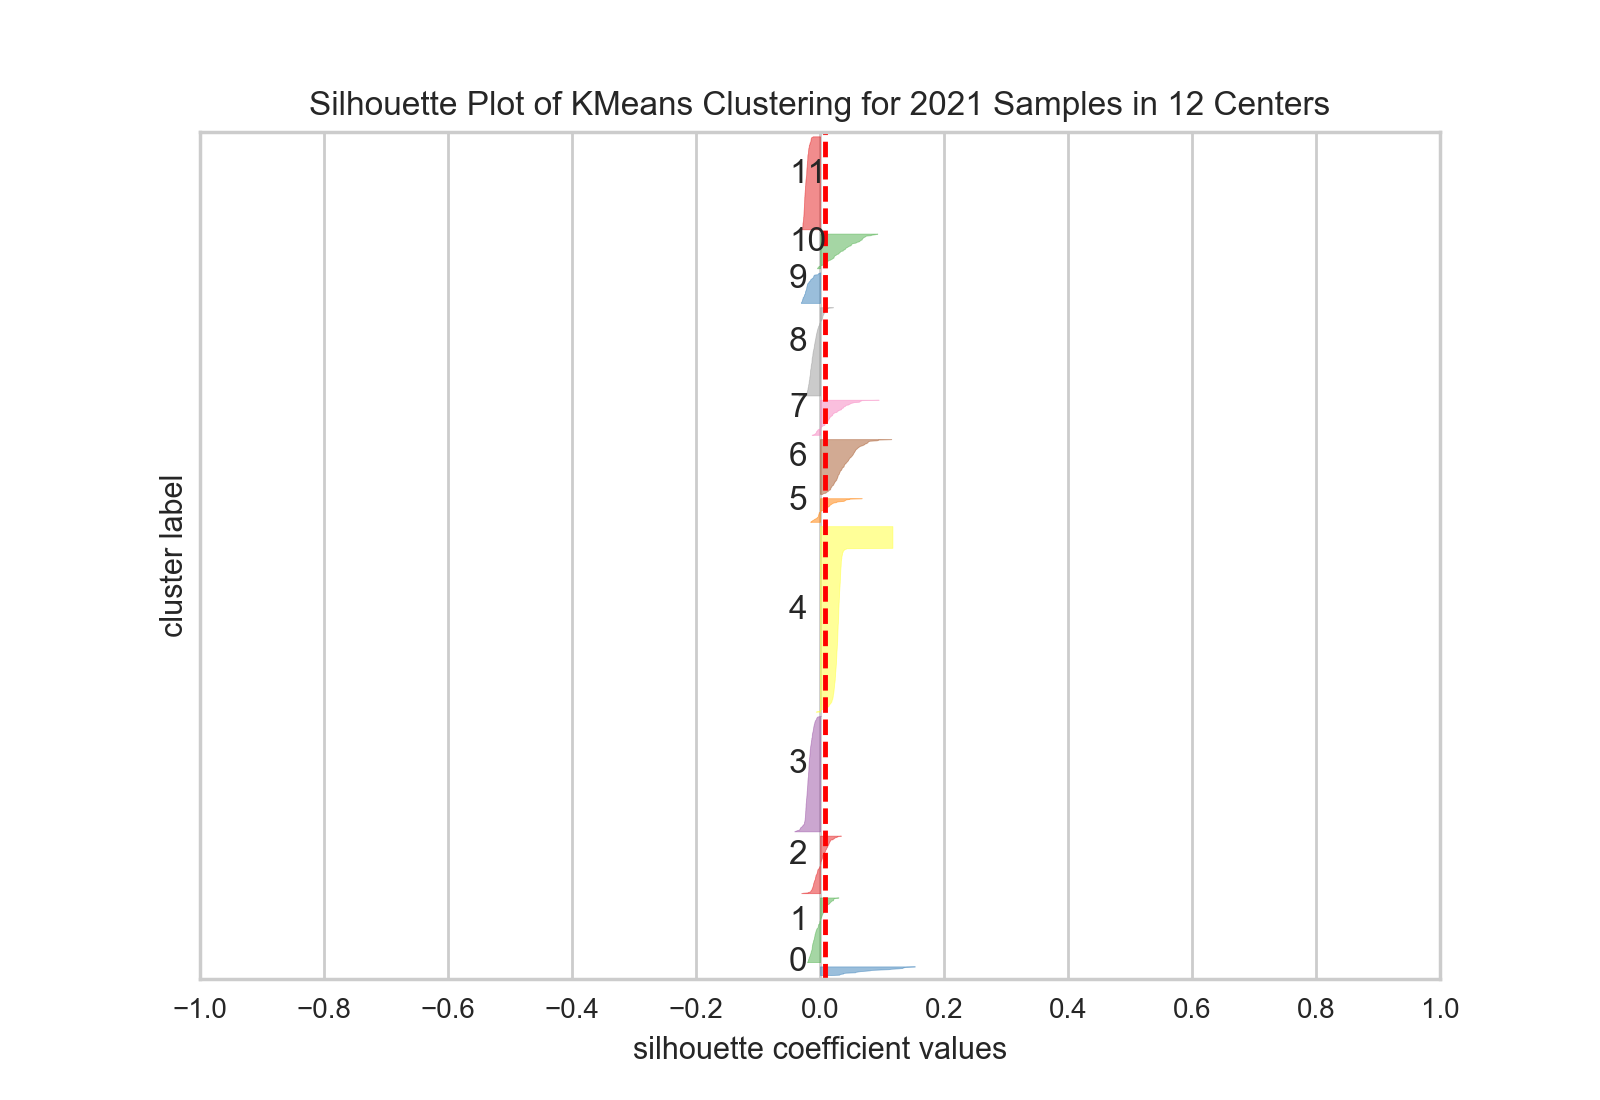

In [33]:
from yellowbrick.cluster import SilhouetteVisualizer  

viz = SilhouetteVisualizer(KMeans(12))
viz.fit(Xt.toarray())
viz.poof()